# Preliminary Dataset Creation (Corrected)
Author: Raphael Pereira Rolim e Silva

> Here, I correct my dataset preparation functions. The previous one only selected the desired DEC and RA range, but didn't prepare the dataset for proper Neural Network usage.

In [2]:
import numpy as np
import healpy as hp
from astropy.io import fits
import matplotlib.pyplot as plt
import sys
###############################
sys.path.insert(1, '/media/BINGODATA1/ComponentSeparation/beam_analyzes/scripts')
import handling_data as hdata
import beam_modelling as model

## Functions

In [5]:
def healpix_to_2d(data, width, height, dec_range, ra_range):
    """
    Returns a 2D projection of an FITS file in (num_bands, height, width).

    Parameters:
    - data: FITS file, HEALPix map
        Desired data already opened.
    - width: int
        Desired width in pixels of projected map.
    - height: int
        Desired height in pixels of projected map.
    - dec_range: array-like
        Range of declination in degrees where dec_range[0] is the minimum and dec_range[1] is the maximum.
    - ra_range: array-like
        Range of right ascension in degrees where ra_range[0] is the minimum and ra_range[1] is the maximum.

    Returns:
    - projection: array-like
        2D projection of the FITS file in (num_bands, height, width).
    """
    if data.ndim > 1:
        nside = hp.get_nside(data[0])
        num_bands = data.shape[0]
    else:
        nside = hp.get_nside(data)
        num_bands = 1

    # Convert RA and Dec to theta (colatitude) and phi (longitude) in radians
    theta_range = np.zeros(2)
    theta_range[0] = np.radians(90.0 - dec_range[1]) # theta_min
    theta_range[1] = np.radians(90.0 - dec_range[0]) # theta_max
    
    phi_range = np.zeros(2)
    phi_range[0] = np.radians(ra_range[0]) # phi_min
    phi_range[1] = np.radians(ra_range[1]) # phi_max

    # Create an array for the 2D projection
    projection = np.zeros((num_bands, height, width))

    # Set up the Mollweide projection grid
    theta = np.linspace(theta_range[0], theta_range[1], height)  # Latitude from 0 to 180 degrees
    phi = np.linspace(phi_range[0], phi_range[1], width)  # Longitude from -180 to 180 degrees
    phi, theta = np.meshgrid(phi, theta)  # Create a mesh grid for theta and phi

    # Convert theta, phi to HEALPix pixel indices
    pix_indices = hp.ang2pix(nside, theta, phi)

    if data.ndim > 1:
        for band in range(num_bands):
            projection[band, :, :] = data[band][pix_indices]  # Map HEALPix data to 2D grid
    else:
        projection[:, :] = data[pix_indices]

    return projection

def smooth_map(healpix_map, nbands=30, nu_min=980, nu_max=1260, D=40, in_degree=True, type_='gaussian'):
    """
    Process a HEALPix map by adjusting frequency bands, calculating beam window function,
    and smoothing the map.
    The values of this function are adjusted for the BINGO radio-telescope.

    Parameters:
    - healpix_map: array-like
        The HEALPix map data.
    - nbands: int
        Number of frequency bands.
    - nu_min: float
        Minimum frequency of observation.
    - nu_max: float
        Maximum frequency of observation.
    - D: float
        Diameter for the dish.
    - in_degree: bool
        Whether to use degrees in the beam window function.
    - type_: str
        The type of the beam window function.

    Returns:
    - g_smoothed_map: array-like
        The smoothed HEALPix map.
    """
    # Adjusting nu
    nu_step = (nu_max - nu_min) / nbands
    nu = np.around(np.arange(nu_min, nu_max, nu_step), decimals=2)

    # Adjusting ell
    nside = hp.get_nside(healpix_map)
    lmax = 3 * nside
    l = np.arange(lmax + 1)

    # FWHM (Delta theta_r)
    fwhm = model.fwhm_modelling(nu=nu[0], type_='smooth', D=D, in_degree=in_degree)

    # Adjusting theta
    theta = np.arange(0, 10, 0.01)

    # Get beam window function
    bl = model.bl_function(type_=type_, fwhm=fwhm, lmax=lmax, theta_=theta, input_unit='degree')

    # Visualize results
    smoothed_map = hp.smoothing(healpix_map, beam_window=bl)

    return smoothed_map

def array_to_healpix(projection, dec_range, ra_range, nside):
    """
    Convert a 3D array projection into a multi-band HEALPix map.

    Parameters:
    - projection: array-like 
        3D array of shape (num_bands, height, width).
    - dec_range: array-like
        Range of declination in degrees where dec_range[0] is the minimum and dec_range[1] is the maximum.
    - ra_range: array-like
        Range of right ascension in degrees where ra_range[0] is the minimum and ra_range[1] is the maximum.
    - nside: int
        HEALPix nside parameter.

    Returns:
    healpix_map: HEALPix map
        HEALPix map array of shape (num_bands, 12 * nside**2).
    """
    num_bands, height, width = projection.shape
    
    # Initialize HEALPix map array
    if num_bands > 1:
        healpix_map = np.full((num_bands, 12 * nside**2), hp.UNSEEN)
    else:
        healpix_map = np.full(12 * nside**2, hp.UNSEEN)

    # Convert RA and Dec to theta (colatitude) and phi (longitude) in radians
    theta_range = np.radians([90.0 - dec_range[1], 90.0 - dec_range[0]])  # theta_min, theta_max
    phi_range = np.radians(ra_range)  # phi_min, phi_max

    # Set up the Mollweide projection grid
    theta = np.linspace(theta_range[0], theta_range[1], height)  # Latitude from dec_min to dec_max
    phi = np.linspace(phi_range[0], phi_range[1], width)  # Longitude from ra_min to ra_max
    phi, theta = np.meshgrid(phi, theta)  # Create a mesh grid for theta and phi

    # Convert theta, phi to HEALPix pixel indices
    pix_indices = hp.ang2pix(nside, theta.flatten(), phi.flatten())

    if num_bands > 1:
        # Map values to HEALPix pixels for each band
        for band in range(num_bands):
            healpix_map[band, pix_indices] = projection[band].flatten()
    else:
        healpix_map[pix_indices] = projection.flatten()

    return healpix_map

## The work

In [3]:
# Get map
path_HI = "/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/HI256/"
filename = 'HI_I_256_980mhz1260mhz_30bins_full_L0001.fits'
data = hdata.getmap(dirpath_=path_HI, filename_=filename, healpix_readingformat=False, hdu=1)

In [4]:
# Config
width, height = 256, 256
dec = [-4,4]
ra = [-4,4]

i = np.random.randint(0,30)

### Original maps with convolutions

In [5]:
# Gaussian beam maps
g_smoothed_map = smooth_map(data[i], type_='gaussian')

# Cosine beam maps
c_smoothed_map = smooth_map(data[i], type_='cosine')

# Jinc beam maps
j_smoothed_map = smooth_map(data[i], type_='jinc')

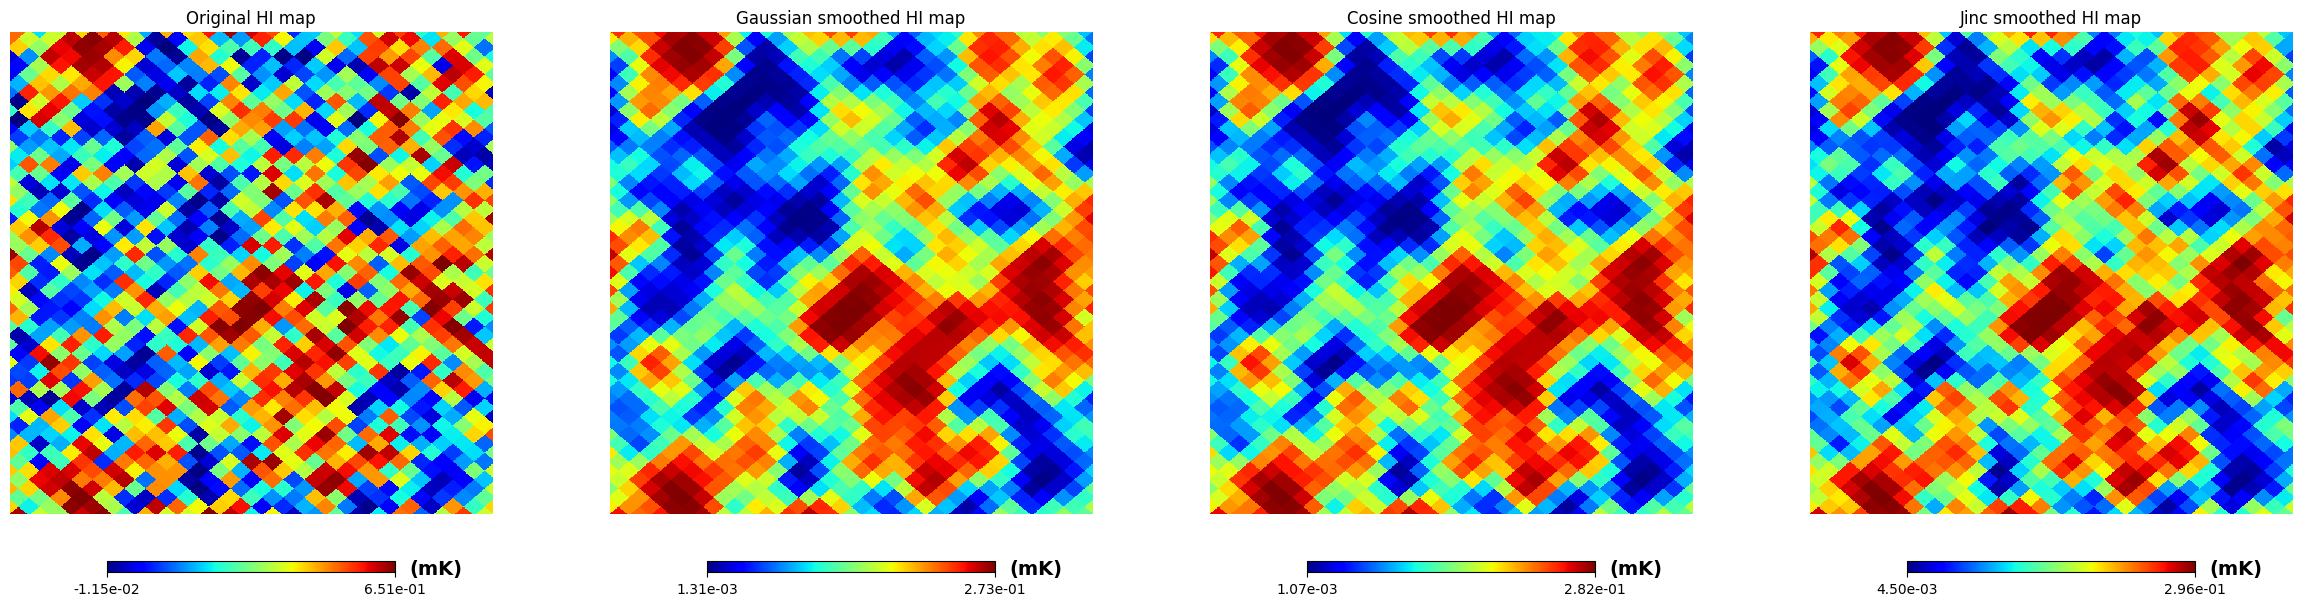

In [6]:
# Plot and compare
fig, axes = plt.subplots(1, 4, figsize=(24, 6),
                         subplot_kw={'projection': None},
                         gridspec_kw={'wspace': 0.1})

smoothed_titles = [
    'Original HI map',
    'Gaussian smoothed HI map',
    'Cosine smoothed HI map',
    'Jinc smoothed HI map'
]

maps = [data[i], g_smoothed_map, c_smoothed_map, j_smoothed_map]

# Plot each map individually
hp.cartview(maps[0], norm="hist", latra=[dec[0],dec[1]], lonra=[ra[0],ra[1]], cmap='jet', format='%.2e', 
            unit=r'(mK)', title=smoothed_titles[0], fig=fig, sub=(1, 4, 1))
hp.cartview(maps[1], norm="hist", latra=[dec[0],dec[1]], lonra=[ra[0],ra[1]], cmap='jet', format='%.2e', 
            unit=r'(mK)', title=smoothed_titles[1], fig=fig, sub=(1, 4, 2))
hp.cartview(maps[2], norm="hist", latra=[dec[0],dec[1]], lonra=[ra[0],ra[1]], cmap='jet', format='%.2e', 
            unit=r'(mK)', title=smoothed_titles[2], fig=fig, sub=(1, 4, 3))
hp.cartview(maps[3], norm="hist", latra=[dec[0],dec[1]], lonra=[ra[0],ra[1]], cmap='jet', format='%.2e', 
            unit=r'(mK)', title=smoothed_titles[3], fig=fig, sub=(1, 4, 4))

# Hide the axes for all subplots to remove traces
for ax in axes:
    ax.set_axis_off()

#plt.savefig('limited_cartview_maps.png', bbox_inches='tight')

plt.show()

### 2D projections with convolutions

In [7]:
def plot_projection_info(ax, projection, title, bins):
    """
    Plot projection information including shape and histogram.

    Parameters:
    ax (matplotlib.axes.Axes): Axes object to plot on.
    projection (numpy.ndarray): 2D array representing the projection.
    title (str): Title for the plot.
    """
    # Compute the histogram of the data
    hist, bins = np.histogram(projection.flatten(), bins=bins, density=True)

    # Normalize the histogram manually
    hist /= hist.sum()

    # Display the projected map
    im = ax.imshow(projection[0], origin='lower', norm=plt.Normalize(hist.min(), hist.max()), cmap='jet')
    ax.set_title(title)  # Set the title on the plot
    ax.axis('off')
    return im

In [8]:
# Projections
og_projection = healpix_to_2d(data, width, height, dec, ra)

# Gaussian beam
g_projection = healpix_to_2d(g_smoothed_map, width, height, dec, ra)

# Cosine beam
c_projection = healpix_to_2d(c_smoothed_map, width, height, dec, ra)

# Jinc beam
j_projection = healpix_to_2d(j_smoothed_map, width, height, dec, ra)

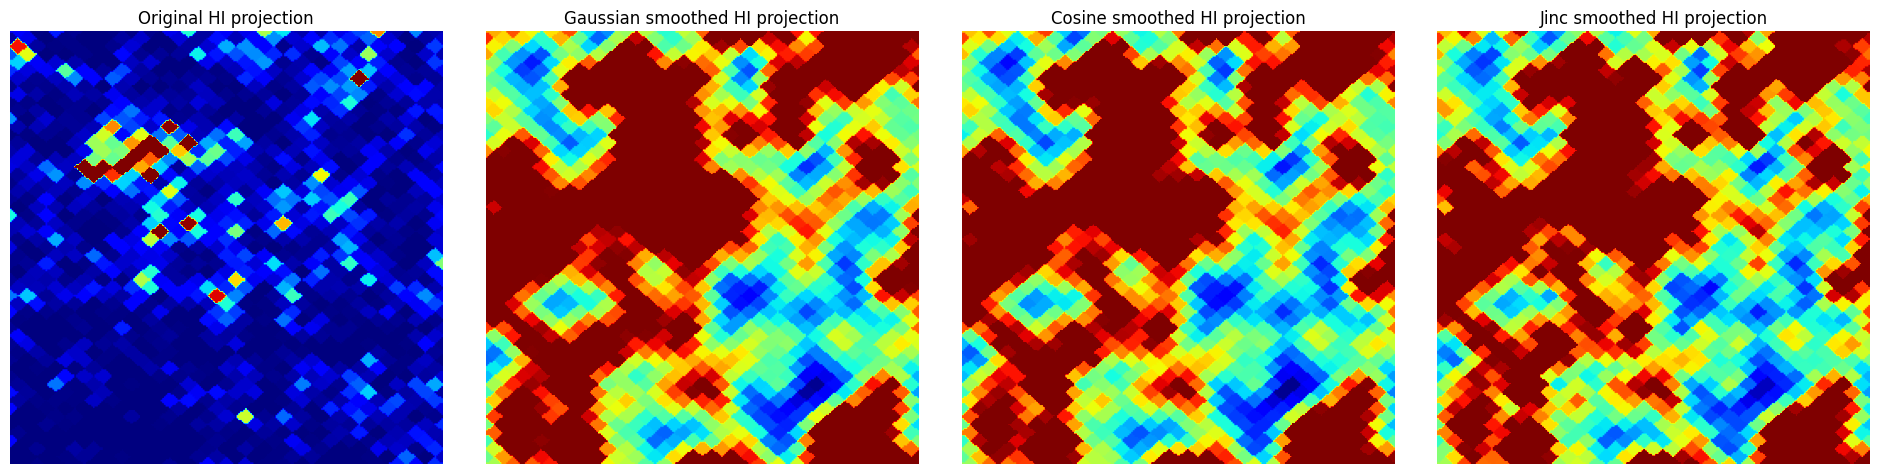

In [9]:
# Plot and compare
fig, axes = plt.subplots(1, 4, figsize=(24, 6),
                         subplot_kw={'projection': None},
                         gridspec_kw={'wspace': 0.1})

titles = [
    'Original HI projection',
    'Gaussian smoothed HI projection',
    'Cosine smoothed HI projection',
    'Jinc smoothed HI projection'
]

projections = [og_projection, g_projection, c_projection, j_projection]

for ax, title, projection in zip(axes, titles, projections):
    plot_projection_info(ax, projection, title, bins=50)

plt.show()

> Note that the projections are inverted, that's why the pictures look different from the original ones.

> Also, the histogram normalization here is different from the HEALPix one.

### Array to maps with convolutions

In [22]:
# Array to HEALPix maps
og_healpix = array_to_healpix(og_projection, dec, ra, nside=256)

# Gaussian beam
g_healpix = array_to_healpix(g_projection, dec, ra, nside=256)

# Cosine beam
c_healpix = array_to_healpix(c_projection, dec, ra, nside=256)

# Jinc beam
j_healpix = array_to_healpix(j_projection, dec, ra, nside=256)

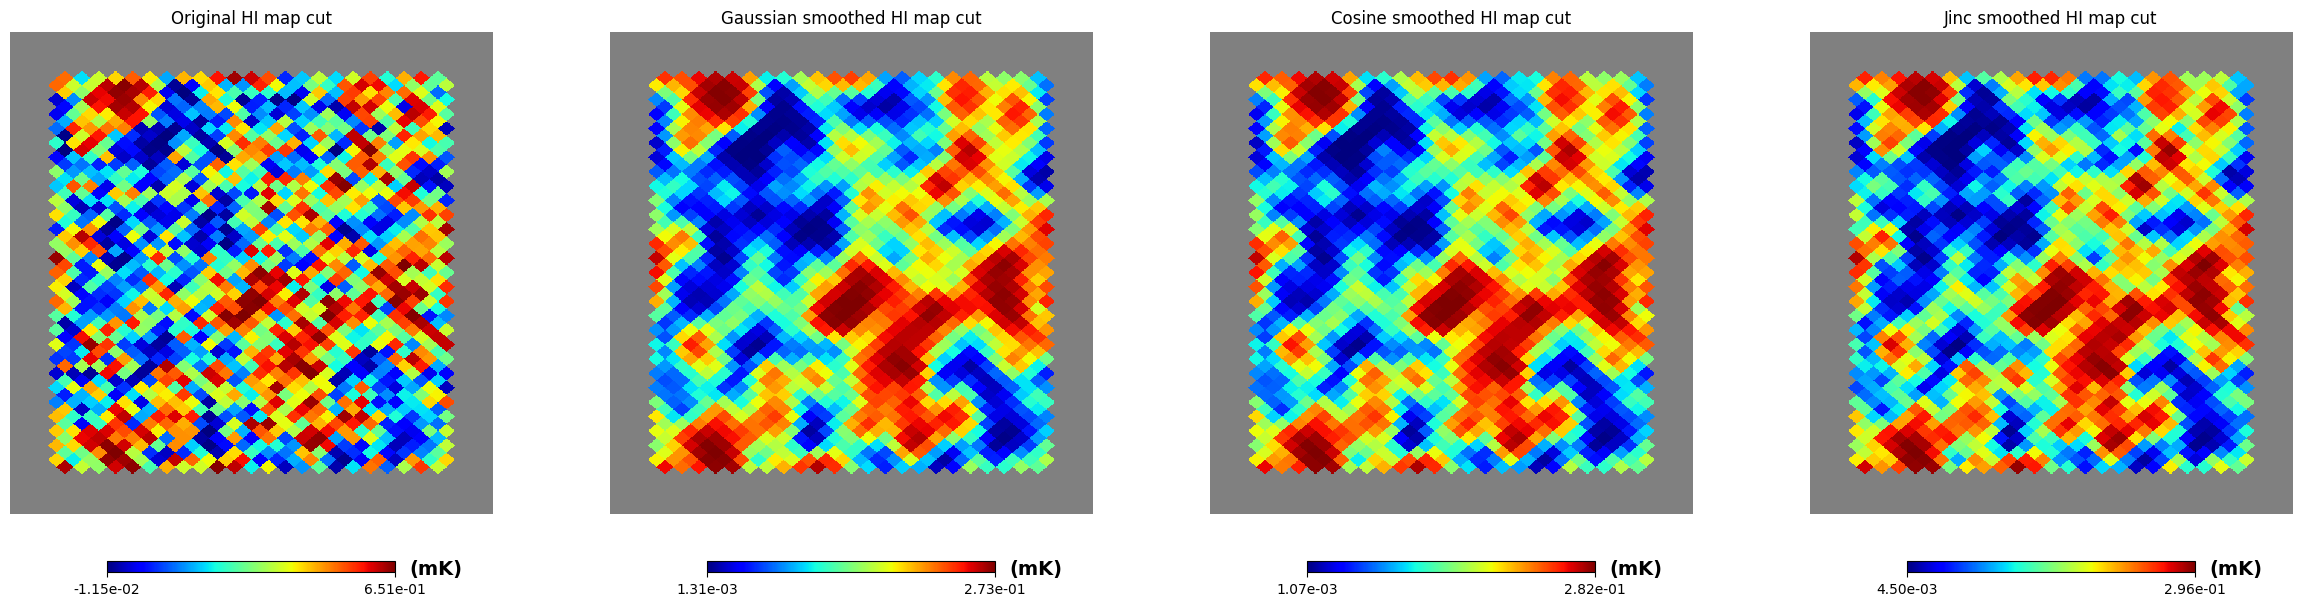

In [29]:
# Plot and compare
new_dec = [-5,5]
new_ra = [-5,5]

fig, axes = plt.subplots(1, 4, figsize=(24, 6),
                         subplot_kw={'projection': None},
                         gridspec_kw={'wspace': 0.1})

titles = [
    'Original HI map cut',
    'Gaussian smoothed HI map cut',
    'Cosine smoothed HI map cut',
    'Jinc smoothed HI map cut'
]

healpix_maps = [og_healpix[i], g_healpix, c_healpix, j_healpix]

# Plot each map individually
hp.cartview(healpix_maps[0], norm="hist", latra=[new_dec[0],new_dec[1]], lonra=[new_ra[0],new_ra[1]], cmap='jet', format='%.2e', 
            unit=r'(mK)', title=titles[0], fig=fig, sub=(1, 4, 1))
hp.cartview(healpix_maps[1], norm="hist", latra=[new_dec[0],new_dec[1]], lonra=[new_ra[0],new_ra[1]], cmap='jet', format='%.2e', 
            unit=r'(mK)', title=titles[1], fig=fig, sub=(1, 4, 2))
hp.cartview(healpix_maps[2], norm="hist", latra=[new_dec[0],new_dec[1]], lonra=[new_ra[0],new_ra[1]], cmap='jet', format='%.2e', 
            unit=r'(mK)', title=titles[2], fig=fig, sub=(1, 4, 3))
hp.cartview(healpix_maps[3], norm="hist", latra=[new_dec[0],new_dec[1]], lonra=[new_ra[0],new_ra[1]], cmap='jet', format='%.2e', 
            unit=r'(mK)', title=titles[3], fig=fig, sub=(1, 4, 4))

# Hide the axes for all subplots to remove traces
for ax in axes:
    ax.set_axis_off()

#plt.savefig('limited_cartview_maps.png', bbox_inches='tight')

plt.show()

### Final regards

The objective of this notebook was to create 2 functions:
- healpix_to_2d: Turn HEALPix maps into 2D images.
- array_to_healpix: Turn our images back into HEALPix maps.

And as a result, I could succesfully create those functions, where the transformations preserve the brightness of each pixel, their positions in the sky and desired range (Pixels outside this range are turned into `hp.UNSEEN` values).

## Save dataset

In [3]:
# Get map
path_HI = "/media/BINGODATA1/ComponentSeparation/building_dataset/dataset/HI256/"
filename = 'HI_I_256_980mhz1260mhz_30bins_full_L0001.fits'
data = hdata.getmap(dirpath_=path_HI, filename_=filename, healpix_readingformat=False, hdu=1)

In [4]:
# Config
width, height = 256, 256
dec = [-4,4]
ra = [-4,4]

In [6]:
for i in range(len(data)):
    # Original maps
    og_map = data[i]
    og_projection = healpix_to_2d(og_map, width, height, dec, ra)

    # Gaussian maps
    g_map = smooth_map(og_map, type_='gaussian')
    g_projection = healpix_to_2d(g_map, width, height, dec, ra)

    # Cosine maps
    c_map = smooth_map(og_map, type_='cosine')
    c_projection = healpix_to_2d(c_map, width, height, dec, ra)

    # Jinc maps
    j_map = smooth_map(og_map, type_='jinc')
    j_projection = healpix_to_2d(j_map, width, height, dec, ra)

    # Save maps
    np.save(f'./preliminary_dataset/og_maps/og_map_{i}.npy', og_projection)
    np.save(f'./preliminary_dataset/g_smoothed_maps/g_smoothed_map_{i}.npy', g_projection)
    np.save(f'./preliminary_dataset/c_smoothed_maps/c_smoothed_map_{i}.npy', c_projection)
    np.save(f'./preliminary_dataset/j_smoothed_maps/j_smoothed_map_{i}.npy', j_projection)

In [124]:
# Check shapes
j = np.random.randint(0,30)
    
og_projection = np.load(f'./preliminary_dataset/og_maps/og_map_{j}.npy')
print(f'Shape of Original Map {j}:', og_projection.shape)

g_projection = np.load(f'./preliminary_dataset/g_smoothed_maps/g_smoothed_map_{j}.npy')
print(f'Shape of Gaussian Map {j}:', g_projection.shape)

c_projection = np.load(f'./preliminary_dataset/c_smoothed_maps/c_smoothed_map_{j}.npy')
print(f'Shape of Cosine Map {j}:', c_projection.shape)

j_projection = np.load(f'./preliminary_dataset/j_smoothed_maps/j_smoothed_map_{j}.npy')
print(f'Shape of Jinc Map {j}:', j_projection.shape)

Shape of Original Map 17: (1, 256, 256)
Shape of Gaussian Map 17: (1, 256, 256)
Shape of Cosine Map 17: (1, 256, 256)
Shape of Jinc Map 17: (1, 256, 256)
